# **CSE552 Homework 4**

* **GTU Artificial Intelligence MSc.**
* **Student Name:** Berkin Barış Yılmaz
* **ID:** 244201001109

* [github.com/Berkin99/MachineLearning](https://github.com/Berkin99/MachineLearning)

## **K-Means Clustering**
Use an existing k-means algorithm with three different distance metrics: 1) L2 norm (Euclidean
distance), 2) L1 norm (Manhattan distance), and 3) Cosine distance.
Using the transformed data apply k-means algorithm (use k=10 for ten digits) to cluster 80% of the
data and test the result on the remaining 20% of the data (repeat this 5 times for cross validation).
Report the performance of the clustering using the following measurement.

In [1]:
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import manhattan_distances, cosine_distances
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import confusion_matrix
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [2]:


def kmeans_clustering(X, k, metric='euclidean', max_iter=100, random_state=0):
    """
    Run KMeans clustering using specified distance metric.
    - If 'euclidean', uses sklearn's optimized KMeans.
    - For others (e.g. 'cityblock', 'cosine'), runs a manual implementation.
    """
    if metric == 'euclidean':
        model = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels = model.fit_predict(X)
        return labels, model.cluster_centers_

    # Manual KMeans for non-Euclidean distances
    np.random.seed(random_state)
    centroids = X[np.random.choice(len(X), k, replace=False)]
    labels = np.zeros(len(X), dtype=int)

    for _ in range(max_iter):
        dists = cdist(X, centroids, metric=metric)
        labels = np.argmin(dists, axis=1)

        for i in range(k):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                centroids[i] = np.median(cluster_points, axis=0) if metric == 'cityblock' else np.mean(cluster_points, axis=0)

    return labels, centroids

def predict_clusters_1nn(X_test, X_train, train_clusters, metric='euclidean'):
    """
    Use 1-NN to assign test data to clusters based on training data.
    For each test point, find the closest training point and assign its cluster.
    """
    # Initialize the nearest neighbors model with k=1
    nn_model = NearestNeighbors(n_neighbors=1, metric=metric)
    nn_model.fit(X_train)
    
    # Find indices of closest training points for each test point
    distances, indices = nn_model.kneighbors(X_test)
    
    # Map each test point to the cluster of its nearest training point
    test_clusters = train_clusters[indices.flatten()]
    
    return test_clusters

def generate_label_cluster_table(cluster_ids, true_labels, k):
    """Build a (10, k) table showing label distribution in clusters."""
    table = np.zeros((10, k), dtype=int)
    for i in range(len(cluster_ids)):
        label = true_labels[i]
        cluster = cluster_ids[i]
        table[label, cluster] += 1
    return table

def reorder_by_argmax(table: np.ndarray) -> tuple[np.ndarray, dict]:
    """
    Reorders columns so that the dominant label in row i moves to column i.
    Also returns a mapping: original_cluster_index → new_label.

    Returns:
        reordered_table (np.ndarray): reordered label-cluster table
        cluster_to_label (dict): original_cluster_index → assigned_label
    """
    assert table.ndim == 2, "Input must be a 2D array"
    tb = table.copy()
    n_rows, n_cols = tb.shape
    col_positions = np.arange(n_cols)  # Track original cluster positions

    for i in range(min(n_rows, n_cols)):
        remaining_max_idx = np.argmax(tb[i, i:])
        max_col_idx = i + remaining_max_idx
        if remaining_max_idx == 0:
            continue
        tb[:, [i, max_col_idx]] = tb[:, [max_col_idx, i]]
        col_positions[i], col_positions[max_col_idx] = col_positions[max_col_idx], col_positions[i]

    # Now col_positions[new_label] = original_cluster_index
    cluster_to_label = {orig: label for label, orig in enumerate(col_positions)}
    return tb, cluster_to_label


def table_plot(data, columns, rows, title="Title", cmap='binary'):
    df = pd.DataFrame(data, columns=columns, index=rows)
    
    plt.figure(figsize=(6, 3))
    ax = sns.heatmap(
        df,
        annot=True,
        fmt='d',
        cmap=cmap,
        linewidths=0.5,   # Grid lines between cells
        linecolor='black',# Grid color
        cbar=False         # Optional: remove colorbar for clarity
    )
    
    ax.xaxis.set_label_position("top")
    ax.xaxis.tick_top()
    ax.set_title(title, fontsize=14, pad=12)
    ax.set_xticklabels(columns, rotation=0)
    ax.set_yticklabels(rows, rotation=0)
    plt.tight_layout()
    plt.show()

def evaluate_accuracy(y_true, cluster_ids, cluster_to_label_map):
    """
    Given true labels and cluster assignments, map clusters to predicted labels using the map,
    then compute confusion matrix and accuracy.

    Returns:
        Confusion matrix, Accuracy
    """
    y_pred = np.array([cluster_to_label_map[c] for c in cluster_ids])
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(10))
    acc = np.trace(cm) / np.sum(cm)
    return cm, acc


In [3]:
# Prepare data
(x, y), _ = mnist.load_data()
x = x.reshape((x.shape[0], -1)) / 255.0
k = 10
columns = [f"C{i}" for i in range(1, k+1)]
rows = [f"Label{i}" for i in range(10)]

# Stratified 5-fold setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
folds = list(skf.split(x, y))


====== Evaluating with L2 Norm ======

--- Fold 1 ---


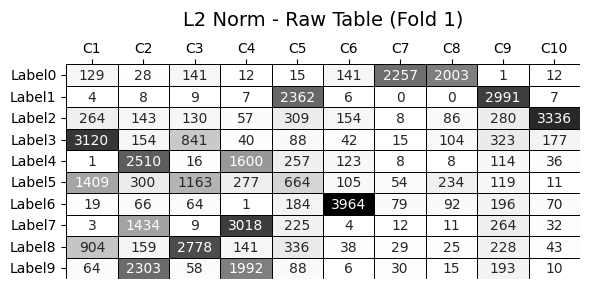

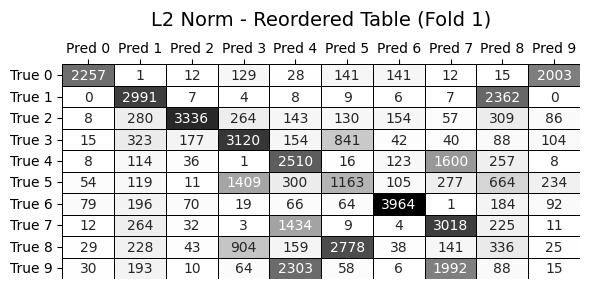

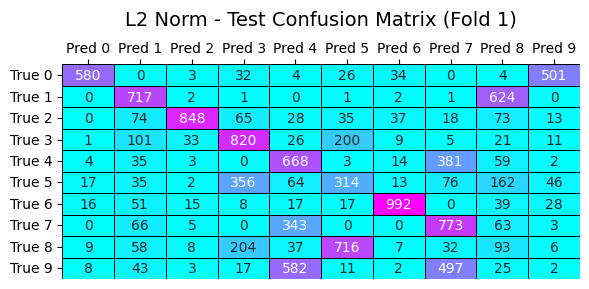

L2 Norm Fold 1 Training Accuracy: 0.4731
L2 Norm Fold 1 Test Accuracy: 0.4839

--- Fold 2 ---


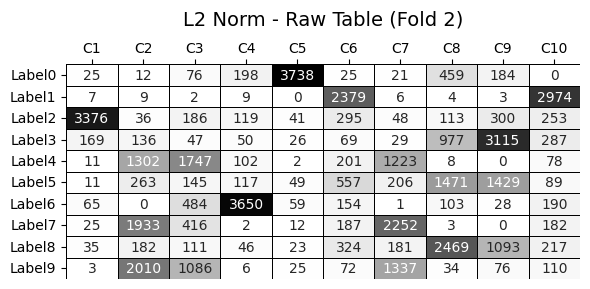

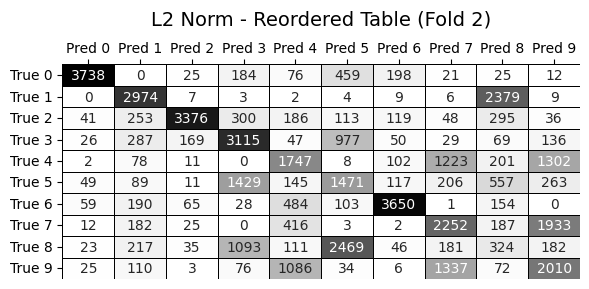

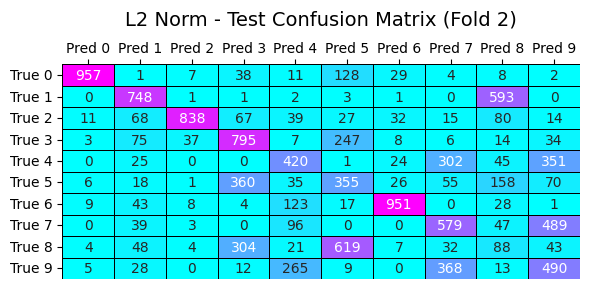

L2 Norm Fold 2 Training Accuracy: 0.5137
L2 Norm Fold 2 Test Accuracy: 0.5184

--- Fold 3 ---


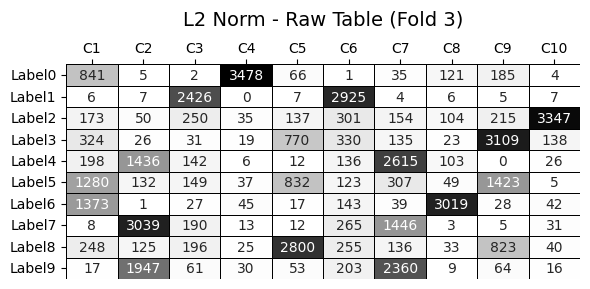

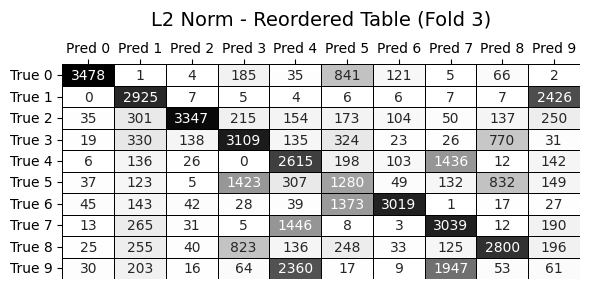

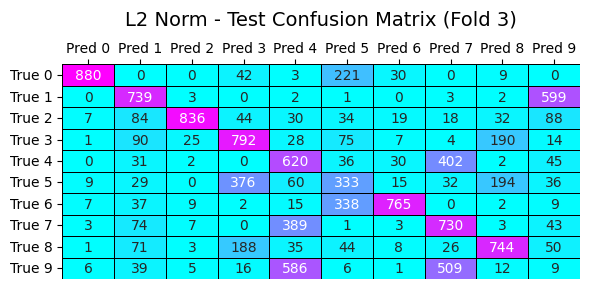

L2 Norm Fold 3 Training Accuracy: 0.5349
L2 Norm Fold 3 Test Accuracy: 0.5373

--- Fold 4 ---


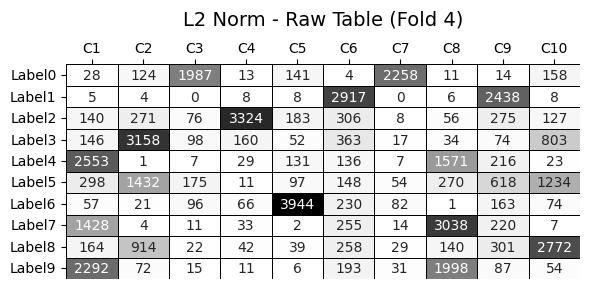

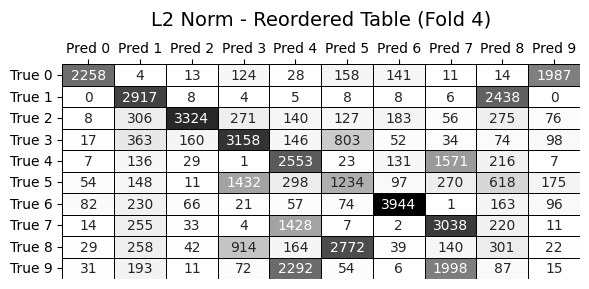

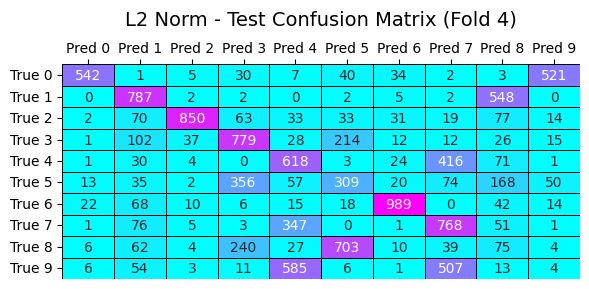

L2 Norm Fold 4 Training Accuracy: 0.4738
L2 Norm Fold 4 Test Accuracy: 0.4768

--- Fold 5 ---


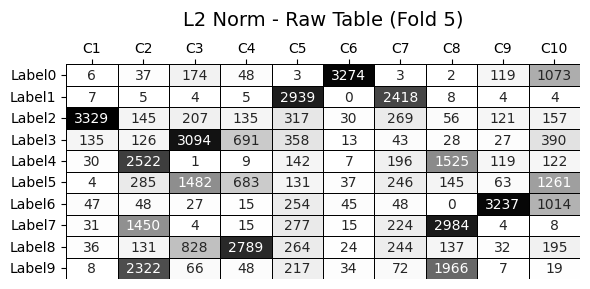

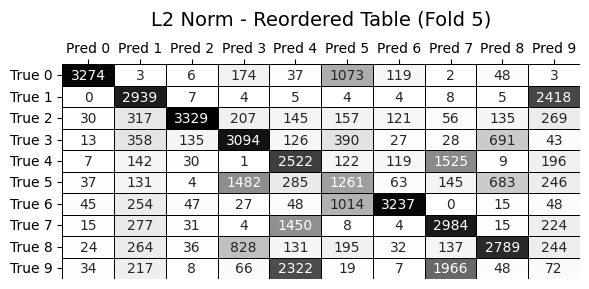

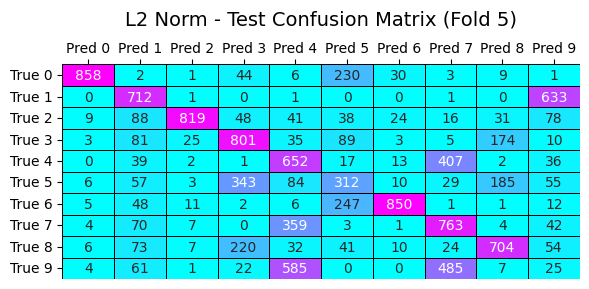

L2 Norm Fold 5 Training Accuracy: 0.5313
L2 Norm Fold 5 Test Accuracy: 0.5413

>>> L2 Norm Averages:
Average Training Accuracy: 0.5053
Average Test Accuracy:     0.5115

====== Evaluating with L1 Norm ======

--- Fold 1 ---


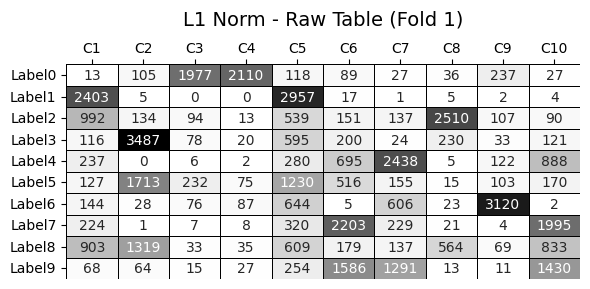

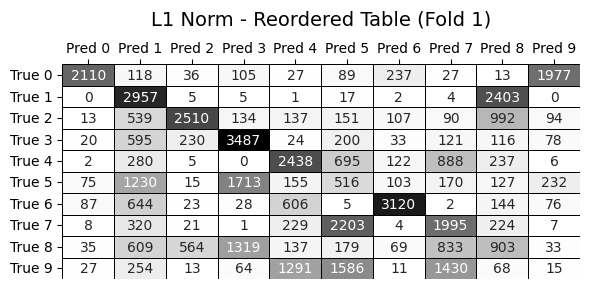

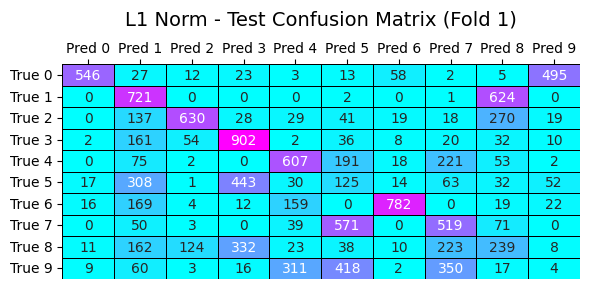

L1 Norm Fold 1 Training Accuracy: 0.4177
L1 Norm Fold 1 Test Accuracy: 0.4229

--- Fold 2 ---


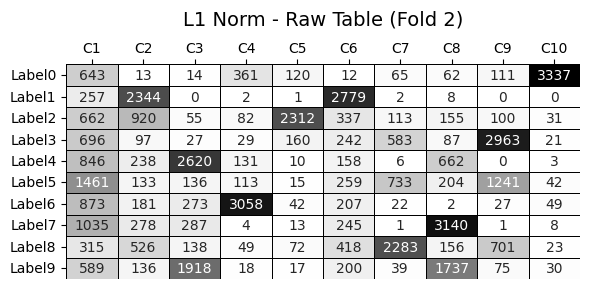

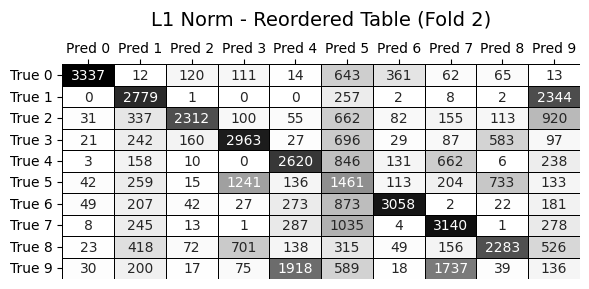

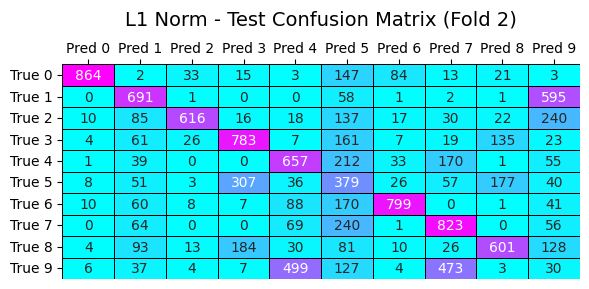

L1 Norm Fold 2 Training Accuracy: 0.5019
L1 Norm Fold 2 Test Accuracy: 0.5202

--- Fold 3 ---


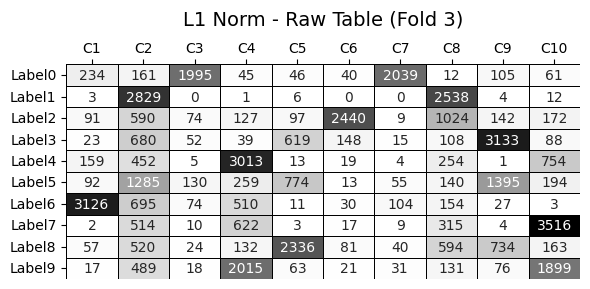

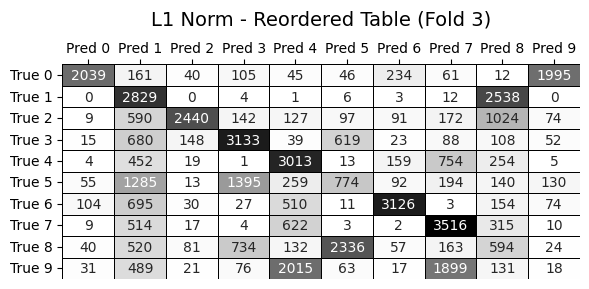

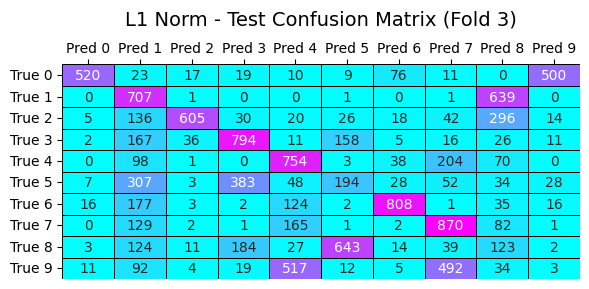

L1 Norm Fold 3 Training Accuracy: 0.4475
L1 Norm Fold 3 Test Accuracy: 0.4482

--- Fold 4 ---


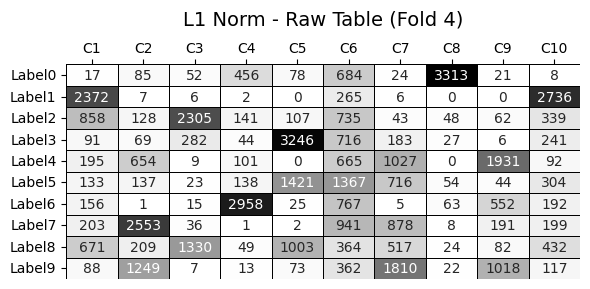

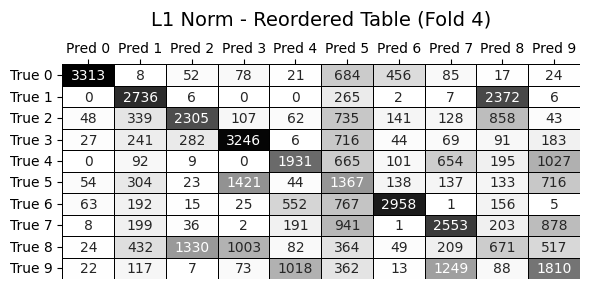

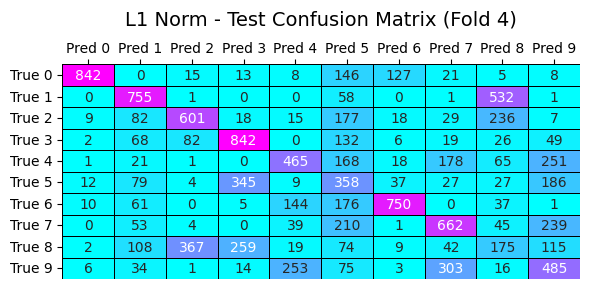

L1 Norm Fold 4 Training Accuracy: 0.4769
L1 Norm Fold 4 Test Accuracy: 0.4946

--- Fold 5 ---


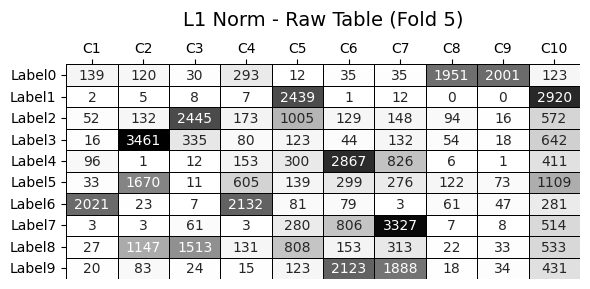

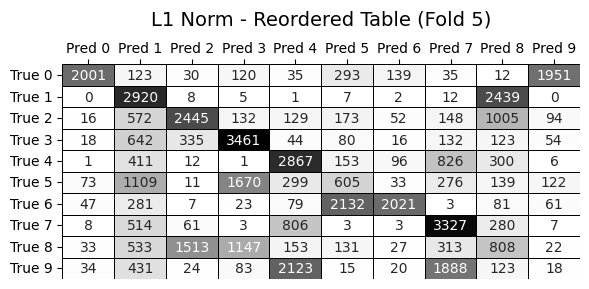

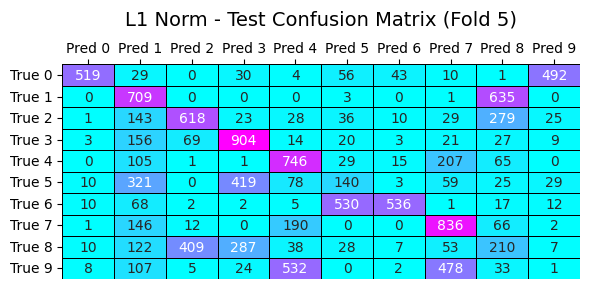

L1 Norm Fold 5 Training Accuracy: 0.4265
L1 Norm Fold 5 Test Accuracy: 0.4349

>>> L1 Norm Averages:
Average Training Accuracy: 0.4541
Average Test Accuracy:     0.4642

====== Evaluating with Cosine Distance ======

--- Fold 1 ---


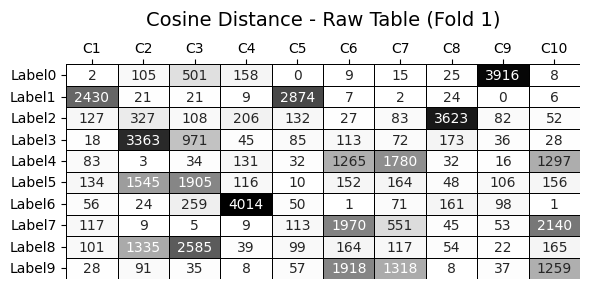

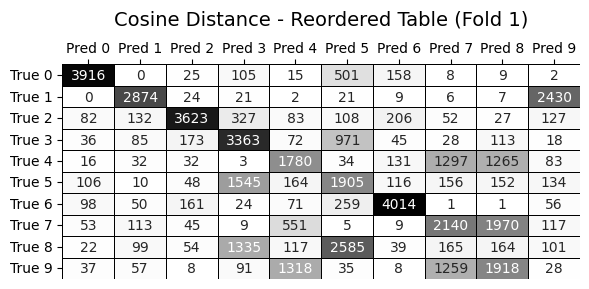

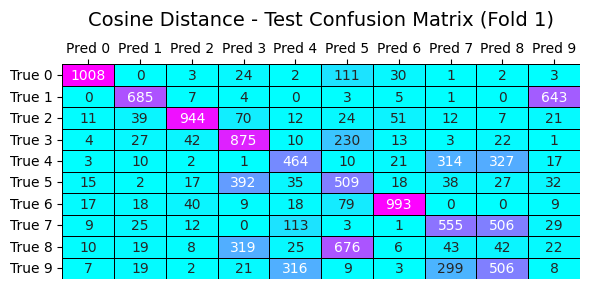

Cosine Distance Fold 1 Training Accuracy: 0.4960
Cosine Distance Fold 1 Test Accuracy: 0.5069

--- Fold 2 ---


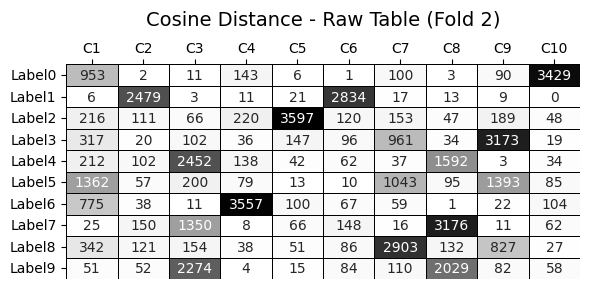

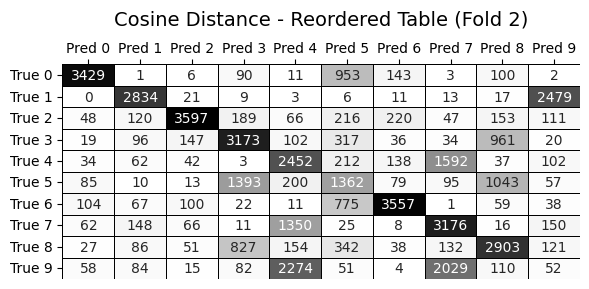

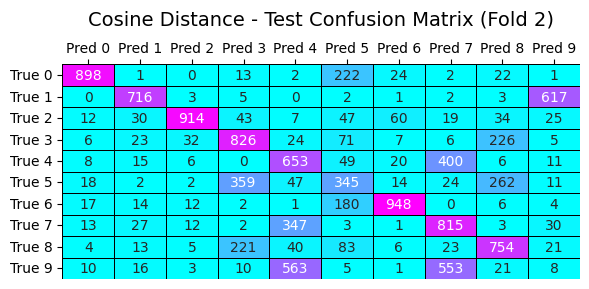

Cosine Distance Fold 2 Training Accuracy: 0.5528
Cosine Distance Fold 2 Test Accuracy: 0.5731

--- Fold 3 ---


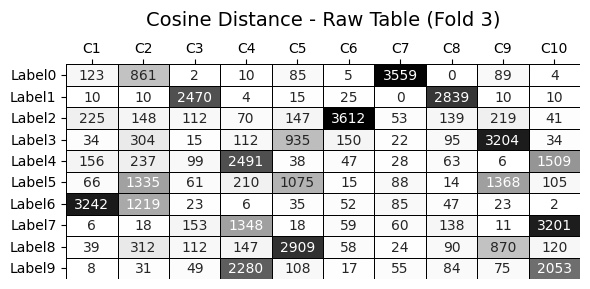

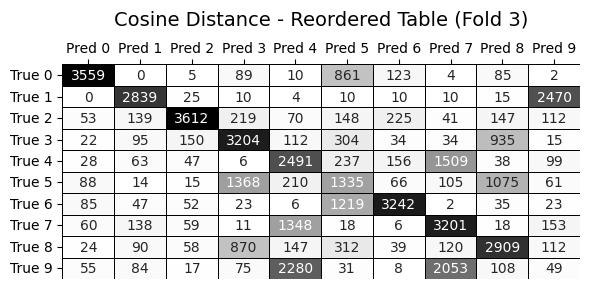

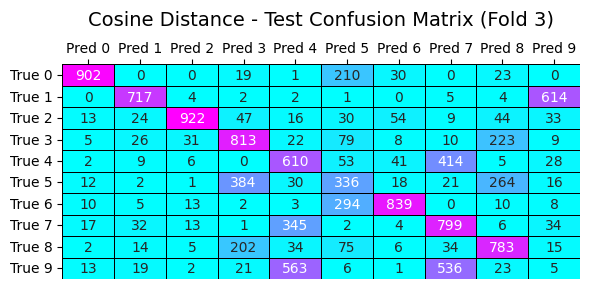

Cosine Distance Fold 3 Training Accuracy: 0.5509
Cosine Distance Fold 3 Test Accuracy: 0.5605

--- Fold 4 ---


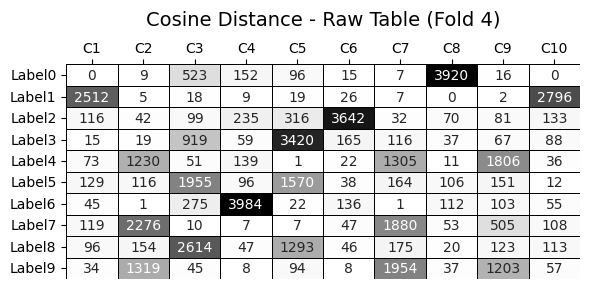

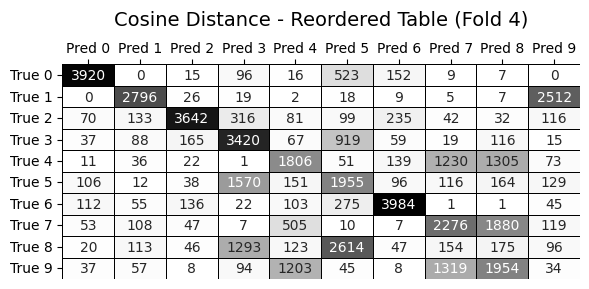

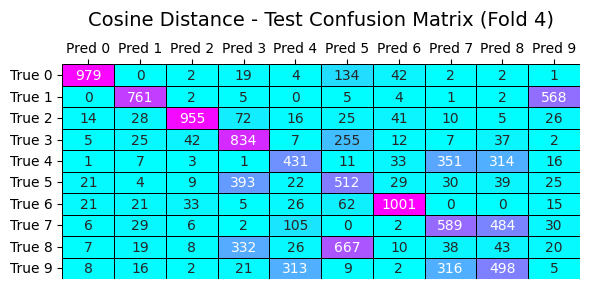

Cosine Distance Fold 4 Training Accuracy: 0.5002
Cosine Distance Fold 4 Test Accuracy: 0.5092

--- Fold 5 ---


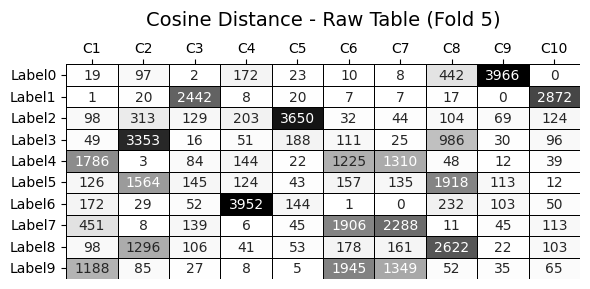

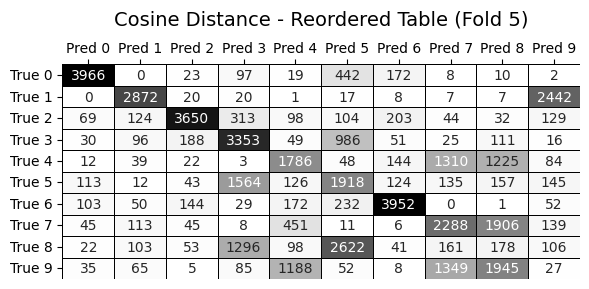

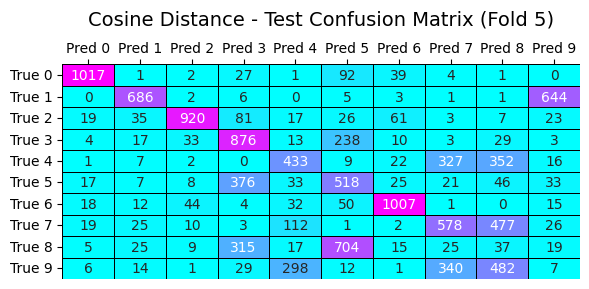

Cosine Distance Fold 5 Training Accuracy: 0.4998
Cosine Distance Fold 5 Test Accuracy: 0.5066

>>> Cosine Distance Averages:
Average Training Accuracy: 0.5199
Average Test Accuracy:     0.5312


In [4]:

# Evaluate for each distance metric
distance_metrics = {
    "euclidean": "L2 Norm",
    "cityblock": "L1 Norm",
    "cosine": "Cosine Distance"
}

for metric_key, metric_name in distance_metrics.items():
    print(f"\n====== Evaluating with {metric_name} ======")
    avg_train_acc, avg_test_acc = 0.0, 0.0

    for fold_idx, (train_idx, test_idx) in enumerate(folds):
        print(f"\n--- Fold {fold_idx+1} ---")
        x_train, y_train = x[train_idx], y[train_idx]
        x_test, y_test = x[test_idx], y[test_idx]

        # Perform clustering on training data
        cluster_ids_train, centroids = kmeans_clustering(x_train, k=k, metric=metric_key)

        # Cluster-Label Table and Reorder
        table = generate_label_cluster_table(cluster_ids_train, y_train, k)
        table_plot(table, columns, rows, title=f"{metric_name} - Raw Table (Fold {fold_idx+1})")
        reordered, cluster_label_map = reorder_by_argmax(table)
        table_plot(reordered, 
                   columns=[f"Pred {i}" for i in range(10)], 
                   rows=[f"True {i}" for i in range(10)], 
                   title=f"{metric_name} - Reordered Table (Fold {fold_idx+1})"
                   )
        
        # Evaluate training accuracy
        train_cm, train_acc = evaluate_accuracy(y_train, cluster_ids_train, cluster_label_map)
        avg_train_acc += train_acc

        # Evaluate test accuracy using 1-NN to assign test points to clusters
        test_cluster_ids = predict_clusters_1nn(x_test, x_train, cluster_ids_train, metric=metric_key)
        test_cm, test_acc = evaluate_accuracy(y_test, test_cluster_ids, cluster_label_map)
        avg_test_acc += test_acc
        
        table_plot(test_cm,
                   columns=[f"Pred {i}" for i in range(10)], 
                   rows=[f"True {i}" for i in range(10)], 
                   title=f"{metric_name} - Test Confusion Matrix (Fold {fold_idx + 1})", 
                   cmap='cool')
        
        print(f"{metric_name} Fold {fold_idx + 1} Training Accuracy: {train_acc:.4f}")
        print(f"{metric_name} Fold {fold_idx + 1} Test Accuracy: {test_acc:.4f}")

    print(f"\n>>> {metric_name} Averages:")
    print(f"Average Training Accuracy: {avg_train_acc / 5:.4f}")
    print(f"Average Test Accuracy:     {avg_test_acc / 5:.4f}")